### Spark MLLib - K-Means

**Description**

- Unsupervised algorithm.
- Grouping of data by similarity.
- Partitions the data into a k-number of clusters, and each observation belongs to only one cluster.
- Clustering is done by measuring the distance between data points and grouping them.
- Multiple distance measurements can be used, such as Euclidean distance and Manhattan distance.

**Pros:** Fast and efficient when you have many variables.

**Cons:** The value of K needs to be known, and its initial value has influence on the clusters created.

**Application:** Preliminary grouping before applying classification techniques, geographical clustering.

### Grouping Cars

In [1]:
import math
import pandas as pd

from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
spSession = SparkSession.builder.master('local').appName('GroupingCars').getOrCreate()

In [3]:
rddCars = sc.textFile('aux/datasets/cars-02.csv')

**We can cache the RDD to optimize performance.**

In [4]:
rddCars.cache()

aux/datasets/cars-02.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [5]:
rddCars.count()

198

In [6]:
rddCars.take(5)

['MAKE,FUELTYPE,ASPIRE,DOORS,BODY,DRIVE,CYLINDERS,HP,RPM,MPG-CITY,MPG-HWY,PRICE',
 'subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348']

In [7]:
header = rddCars.first()

In [8]:
rddCars02 = rddCars.filter(lambda row: row != header)

In [9]:
rddCars02.count()

197

### Data Cleaning

In [10]:
def dataCleaning(strRow):
    listAttr = strRow.split(',')
    
    doors = 1.0 if listAttr[3] == 'two' else 2.0
    body = 1.0 if listAttr[4] == 'sedan' else 2.0
    
    row = Row(
        DOORS = doors,
        BODY  = body,
        HP    = float(listAttr[7]),
        RPM   = float(listAttr[8]),
        MPG   = float(listAttr[9])
    )
    
    return row

In [11]:
rddCars03 = rddCars02.map(dataCleaning)

In [12]:
rddCars03.take(5)

[Row(DOORS=1.0, BODY=2.0, HP=69.0, RPM=4900.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=48.0, RPM=5100.0, MPG=47.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5000.0, MPG=30.0),
 Row(DOORS=1.0, BODY=2.0, HP=62.0, RPM=4800.0, MPG=35.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=37.0)]

**Converting the RDD to a DataFrame**

In [13]:
dfCars = spSession.createDataFrame(rddCars03)

In [14]:
dfCars.cache()

DataFrame[DOORS: double, BODY: double, HP: double, RPM: double, MPG: double]

In [15]:
dfCars.show(5)

+-----+----+----+------+----+
|DOORS|BODY|  HP|   RPM| MPG|
+-----+----+----+------+----+
|  1.0| 2.0|69.0|4900.0|31.0|
|  1.0| 2.0|48.0|5100.0|47.0|
|  1.0| 2.0|68.0|5000.0|30.0|
|  1.0| 2.0|62.0|4800.0|35.0|
|  1.0| 2.0|68.0|5500.0|37.0|
+-----+----+----+------+----+
only showing top 5 rows



### Data Pre-Processing

In [16]:
stats = dfCars.describe().toPandas()

In [17]:
stats

,summary,DOORS,BODY,HP,RPM,MPG
0,count,197,197,197,197,197
1,mean,1.5685279187817258,1.532994923857868,103.60406091370558,5118.0203045685275,25.15228426395939
2,stddev,0.49654352778167493,0.5001812579359883,37.639205349518356,481.03591405011446,6.437862917085915
3,min,1.0,1.0,48.0,4150.0,13.0
4,max,2.0,2.0,262.0,6600.0,49.0


In [18]:
means = stats.iloc[1, 1:5]

In [19]:
means

DOORS    1.5685279187817258
BODY      1.532994923857868
HP       103.60406091370558
RPM      5118.0203045685275
Name: 1, dtype: object

In [20]:
stddevs = stats.iloc[2, 1:5]

In [21]:
stddevs

DOORS    0.49654352778167493
BODY      0.5001812579359883
HP        37.639205349518356
RPM       481.03591405011446
Name: 2, dtype: object

In [22]:
bcMeans = sc.broadcast(means)

In [23]:
bcStdDevs = sc.broadcast(stddevs)

**Function to centralize and scale data.**<br />
Each value will be subtracted from the mean, and then divided by the standard deviation.

In [24]:
def centerAndScale(strRow):
    global bcMeans
    global bcStdDevs
    arrMeans = bcMeans.value
    arrStdDevs = bcStdDevs.value
    arrTreated = []
    
    for i in range(len(arrMeans)):
        arrTreated.append((float(strRow[i]) - float(arrMeans[i])) / float(arrStdDevs[i]))
        
    return Vectors.dense(arrTreated)    

In [25]:
rddCars04 = dfCars.rdd.map(centerAndScale)

In [26]:
rddCars05 = rddCars04.map(lambda feature: Row(features = feature))

In [27]:
dfCars = spSession.createDataFrame(rddCars05)

In [28]:
dfCars.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
+--------------------+
only showing top 5 rows



### Machine Learning

In [29]:
kMeans = KMeans(k = 3, seed = 1)

In [30]:
model = kMeans.fit(dfCars)

In [31]:
model

KMeansModel: uid=KMeans_3c3f09e2f20b, k=3, distanceMeasure=euclidean, numFeatures=4

In [32]:
print(f'K-number: {str(model.getK())}')
print(f'Distance measure: {str(model.getDistanceMeasure())}')

K-number: 3
Distance measure: euclidean


In [33]:
predictions = model.transform(dfCars)

In [34]:
predictions.show(5)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
+--------------------+----------+
only showing top 5 rows



In [35]:
def unstripData(row):
    return (
        row['prediction'],
        row['features'][0],
        row['features'][1],
        row['features'][2],
        row['features'][3]
    )

In [36]:
rddCars06 = predictions.rdd.map(unstripData)

In [37]:
listPredictions = rddCars06.collect()

In [38]:
dfPredictions = pd.DataFrame(listPredictions)

### Plotting the Results

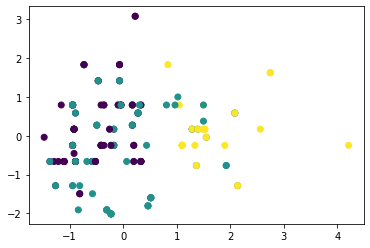

In [39]:
plt.cla()
plt.scatter(dfPredictions[3], dfPredictions[4], c = dfPredictions[0]);